<a href="https://colab.research.google.com/github/binliu0630/transformers/blob/master/Transformer_Binary_Multiclass_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Get Started

In [1]:
import tensorflow as tf
tf.__version__

'1.15.0'

In [2]:
device_name = tf.test.gpu_device_name()

if device_name == '/device:GPU:0':
  print(f'Found GPU at: {device_name}')
else:
  raise SystemError('GPU device not available')

Found GPU at: /device:GPU:0


In [0]:
import torch

In [6]:
if torch.cuda.is_available():
  device = torch.device('cuda')
  print(f'There are {torch.cuda.device_count()} GPU(s) available')
  print(f'We will use the GPU: {torch.cuda.get_device_name()} with the capacity of: {torch.cuda.get_device_capability()}')
else:
  device = torch.device('cpu')
  print(f'No GPU is available, using CPU instead.')
  


There are 1 GPU(s) available
We will use the GPU: Tesla P4 with the capacity of: (6, 1)


In [7]:
!pip install transformers

     |████████████████████████████████| 501kB 35.4MB/s 
     |████████████████████████████████| 870kB 54.5MB/s 
     |████████████████████████████████| 3.7MB 58.3MB/s 
     |████████████████████████████████| 1.0MB 47.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=371751c612498551d67703ff4703658b25a263b19bf3a8eace6e7b5180abc959
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


In [8]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=a78297356f387010d5cbd0a9711d0e4a410f814d54e9848186dc92d8586a2ce0
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [0]:
import wget
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

%matplotlib inline

## Data Prep

In [0]:
url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'

if not os.path.exists('./cola_public_1.1.zip'):
  wget.download(url, './cola_public_1.1.zip')

In [11]:
if not os.path.exists('./cola_public/'):
  !unzip cola_public_1.1.zip

Archive:  cola_public_1.1.zip
   creating: cola_public/
  inflating: cola_public/README      
   creating: cola_public/tokenized/
  inflating: cola_public/tokenized/in_domain_dev.tsv  
  inflating: cola_public/tokenized/in_domain_train.tsv  
  inflating: cola_public/tokenized/out_of_domain_dev.tsv  
   creating: cola_public/raw/
  inflating: cola_public/raw/in_domain_dev.tsv  
  inflating: cola_public/raw/in_domain_train.tsv  
  inflating: cola_public/raw/out_of_domain_dev.tsv  


In [12]:
df = pd.read_csv("./cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
df.sample(10)

,sentence_source,label,label_notes,sentence
4997,ks08,1,NaN,John made it clear that he would finish it on ...
5392,b_73,1,NaN,He seems intelligent enough for you.
1948,r-67,0,?*,I didn't eat the cake or any ice cream.
2052,rhl07,0,*,Jill offered the ball at Bob.
337,bc01,1,NaN,He cannot have been working.
5235,kl93,0,*,I'm glad I saw anybody.
4992,ks08,1,NaN,They denied the claim that we had advanced by ...
5012,ks08,1,NaN,John is ready to please.
851,bc01,0,*,"Sally made Bill laugh, and then José made."
6190,c_13,1,NaN,I wonder what John bought how.


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8551 entries, 0 to 8550
Data columns (total 4 columns):
sentence_source    8551 non-null object
label              8551 non-null int64
label_notes        2527 non-null object
sentence           8551 non-null object
dtypes: int64(1), object(3)
memory usage: 267.3+ KB


In [14]:
df[df['label']==0].sample(5).loc[:, ['sentence', 'label']]

,sentence,label
5024,John is eager to find.,0
2963,The song sang.,0
1633,Bill left when I am looking at a girl who vomi...,0
1514,I never met that man who anybody tried to kill.,0
7121,You can depend on that he will be on time.,0


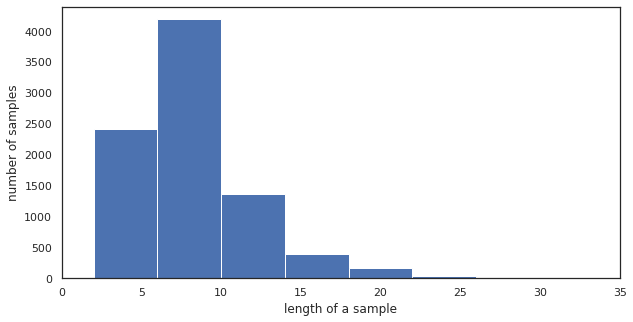

In [19]:

plt.figure(figsize = (10,5))
plt.hist([len(s.split()) for s in df['sentence']], 10)
plt.xlabel('length of a sample')
plt.xlim([0, 35])
plt.ylabel('number of samples')
plt.show()

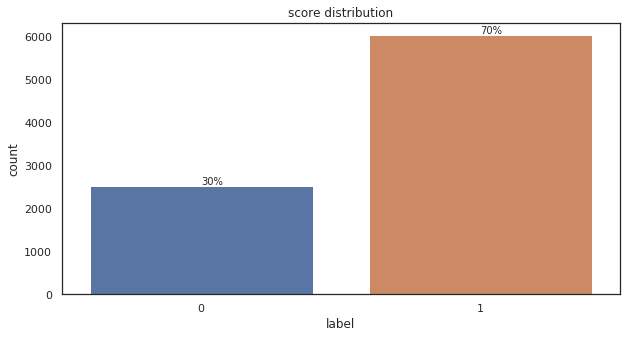

In [21]:
total = len(df)
plt.figure(figsize = (10,5))
ax = sns.countplot(x='label', data=df)
ax.set_title('score distribution')
for p in ax.patches:
  percentage = "{0:.0%}".format(p.get_height()/total)
  x = p.get_x()+p.get_width()/2
  y = p.get_height()+40
  ax.annotate(percentage, (x,y))

In [0]:
sentences = df['sentence'].values
labels = df['label'].values

## Tokenization & Input formatting

In [22]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [0]:
MODEL_NAME = 'roberta-base'
MODEL_NAME = "bert-base-uncased"
# MODEL_NAME = 'albert-base-v1'
# MODEL_NAME = 'flaubert-small-cased'
BATCH_SIZE = 32

In [44]:
tokenzier = AutoTokenizer.from_pretrained(MODEL_NAME)

In [0]:
token = tokenzier.batch_encode_plus(sentences, max_length=64, pad_to_max_length=True)

In [46]:
token.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [0]:
input_ids = token['input_ids']
attention_mask = token['attention_mask']

In [0]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_mask, labels, random_state=2018, test_size=0.1)

In [0]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [0]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_inputs)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

In [0]:
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_inputs)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=BATCH_SIZE)

## Model Training

In [52]:
config=AutoConfig.from_pretrained(MODEL_NAME, num_labels=2)
config

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": null,
  "do_sample": false,
  "eos_token_ids": null,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-12,
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_beams": 1,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "num_return_sequences": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pad_token_id": null,
  "pruned_heads": {},
  "repetition_penalty": 1.0,
  "temperature": 1.0,
  "top_k": 50,
  "top_p": 1.0,
  "torchscript": false,
  "type_vocab_size": 2,
  "use_bfloat16

In [53]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=config)
model.cuda();

In [0]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [0]:
EPOCHS = 4
total_steps = len(train_dataloader) * EPOCHS

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [0]:
import numpy as np
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [58]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
SEED_VAL = 42

random.seed(SEED_VAL)
np.random.seed(SEED_VAL)
torch.manual_seed(SEED_VAL)
torch.cuda.manual_seed_all(SEED_VAL)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, EPOCHS):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print(f'======== Epoch {epoch_i+1} / {EPOCHS} ========')
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:17.
  Batch    80  of    241.    Elapsed: 0:00:34.
  Batch   120  of    241.    Elapsed: 0:00:50.
  Batch   160  of    241.    Elapsed: 0:01:07.
  Batch   200  of    241.    Elapsed: 0:01:24.
  Batch   240  of    241.    Elapsed: 0:01:41.

  Average training loss: 0.49
  Training epcoh took: 0:01:42

Running Validation...
  Accuracy: 0.80
  Validation took: 0:00:03

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:17.
  Batch    80  of    241.    Elapsed: 0:00:34.
  Batch   120  of    241.    Elapsed: 0:00:52.
  Batch   160  of    241.    Elapsed: 0:01:09.
  Batch   200  of    241.    Elapsed: 0:01:26.
  Batch   240  of    241.    Elapsed: 0:01:43.

  Average training loss: 0.30
  Training epcoh took: 0:01:43

Running Validation...
  Accuracy: 0.81
  Validation took: 0:00:03

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:17.
  

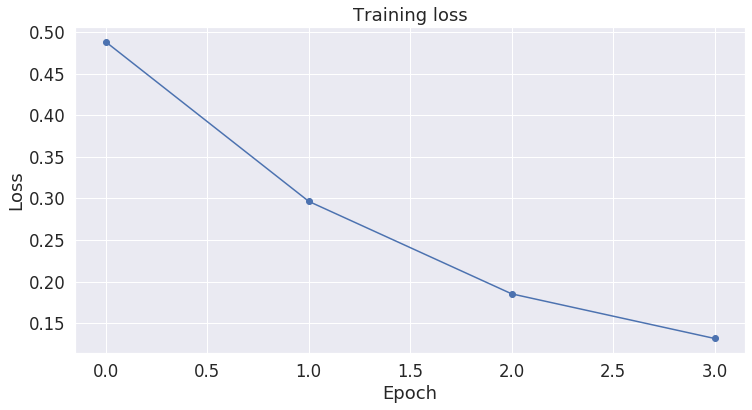

In [59]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

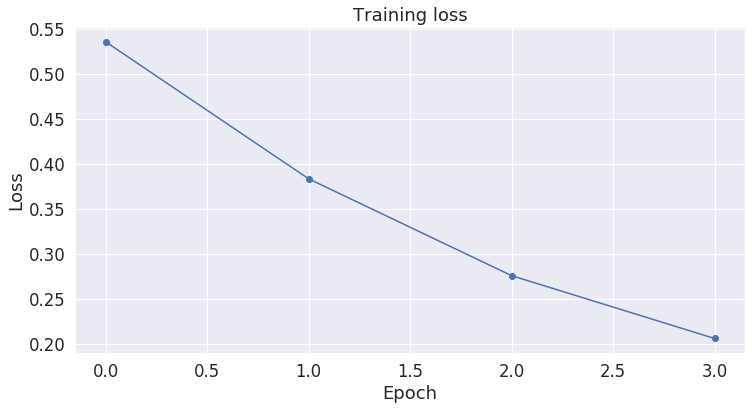

In [134]:
# 	albert-base-v1
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

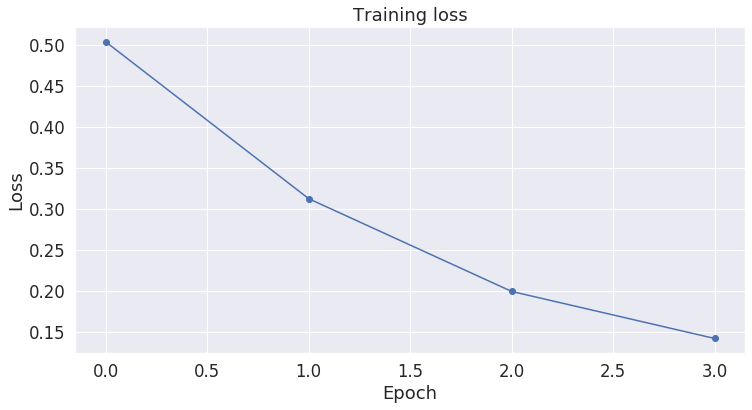

In [95]:
# Bert
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

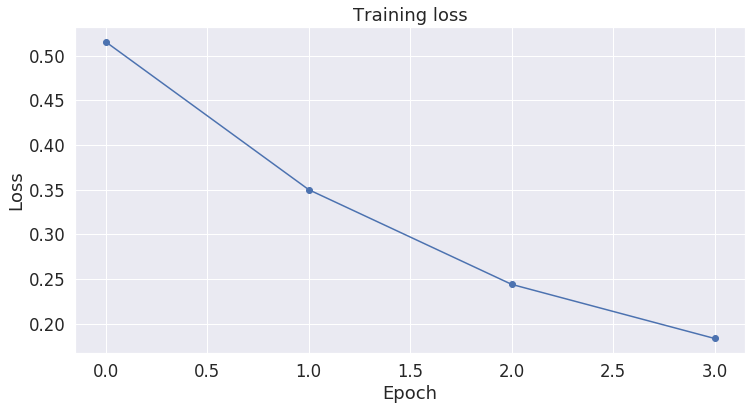

In [68]:
# Roberta
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()